In [273]:
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import NMF
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Activation
from keras.callbacks import EarlyStopping
from keras import optimizers, utils, initializers

In [28]:
root = "./boat-types-recognition/"

In [29]:
## Helper Functions

def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()

In [30]:
## Original Data Size
print("Calculating original data size ...")

count = 0
heights = []
widths = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if not name.endswith(".jpg"):
            continue
        img_path = os.path.join(path, name)
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        
        count += 1
        writeProgress("Progress calculating: ", count, 1462)

min_height = min(heights)
min_width = min(widths)
total = count

Calculating original data size ...


In [31]:
print("Number of image: ", total)
print("Min image height: ", min_height)
print("Min image width: ", min_width)

Number of image:  1462
Min image height:  261
Min image width:  309


In [35]:
resize_W, resize_H = 200, 200

In [249]:
## Resize and Read image into ndarray

count = 0
images = []
labels = []
for path, subdirs, files in os.walk(root):
#     if not path.endswith("buoy") and not path.endswith("cruise ship"):
#             continue
    
    for (i, name) in enumerate(files):
        if not name.endswith(".jpg"):
            continue
        
        label = os.path.basename(path)
        img_path = os.path.join(path, name)
        img = Image.open(img_path)
        img = img.resize((resize_W, resize_H), Image.ANTIALIAS)
        img = img.convert("L")
        img = np.array(img)
        
        images.append(img)
        labels.append(label)
        
        count += 1
        writeProgress("Progress loading images: ", count, total)


X = np.array(images)
Y = np.array(labels)

In [250]:
## Data Size (after resizing)
print("X shape: ", X.shape)
print("Y size: ", Y.shape)

X shape:  (1462, 200, 200)
Y size:  (1462,)


(200, 200)
Class:  buoy


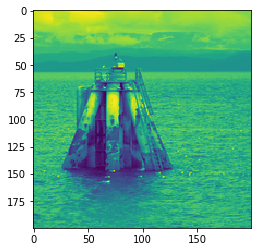

In [251]:
plt.imshow(X[0])
print(X[0].shape)
print("Class: ", Y[0])

In [269]:
## Reshape X for NMF

X_nmf = X.reshape(X.shape[0], -1)

In [270]:
## Reshape Data Y for RNN

onehotEncoder = OneHotEncoder(dtype=np.int)
Y_enc = onehotEncoder.fit_transform(Y.reshape(-1,1))

print(Y_enc.shape)

(1462, 9)


In [271]:
## Split Test/ Train
print("Spliting Test / Train sets ...")

X_train, X_test, y_train, y_test = train_test_split(X_nmf, Y_enc, test_size=0.3, random_state=42)

Spliting Test / Train sets ...


In [272]:
## Data Size (after spliting)
print("X train shape: ", X_train.shape)
print("Y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (1023, 40000)
Y train shape:  (1023, 9)
X test shape:  (439, 40000)
Y test shape:  (439, 9)


In [318]:
## NMF Param
components = 900

In [319]:
## NMF
print("NMF ...")

nmf = NMF(n_components=components, init='random', random_state=0, tol=0.1, verbose=True)

W = nmf.fit_transform(X_train)
H = nmf.components_

NMF ...
violation: 1.0
violation: 0.20869246318004084
violation: 0.10653595365979318
violation: 0.08348245189555957
Converged at iteration 4


In [320]:
X_reduced = W
X_recovered = nmf.inverse_transform(X_reduced)

In [321]:
## Data Size
print("Reduced Shape: " + str(X_reduced.shape))
print("Recovered Shape: " + str(X_recovered.shape))

Reduced Shape: (1023, 900)
Recovered Shape: (1023, 40000)


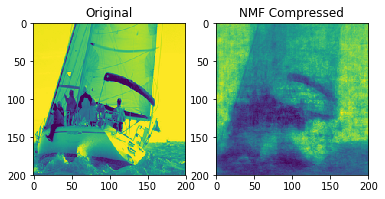

In [322]:
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.title("Original")
plt.imshow(X_train[0].reshape(X.shape[1], X.shape[2]))

f.add_subplot(1,2, 2)
plt.title("NMF Compressed")
plt.imshow(X_recovered[0].reshape(X.shape[1], X.shape[2]))

plt.show(block=True)

In [323]:
## Reshape X for RNN

X_rnn = X_reduced.reshape(X_reduced.shape[0], -1, 1)

X_test_reduced = nmf.transform(X_test)
X_test_rnn = X_test_reduced.reshape(X_test_reduced.shape[0], -1, 1)

violation: 1.0
violation: 0.6156683541833643
violation: 0.4140907418153758
violation: 0.3213240520691258
violation: 0.26947368446994474
violation: 0.24003246121992453
violation: 0.2192654023041786
violation: 0.2009062459469483
violation: 0.185880841269288
violation: 0.17552172465094437
violation: 0.1665203092743036
violation: 0.16025303459153076
violation: 0.1544427053014055
violation: 0.14711087989801944
violation: 0.1427604425388423
violation: 0.13968929530729915
violation: 0.1356579351649519
violation: 0.13126435384449403
violation: 0.12639771943625472
violation: 0.12259433103095783
violation: 0.11959755138739982
violation: 0.11591740712288721
violation: 0.11255386911468479
violation: 0.10865535784068497
violation: 0.10545583431242624
violation: 0.10217978462207764
violation: 0.09910090110642396
Converged at iteration 27


In [324]:
## Model Params
batch_size = 32
num_classes = 9
epochs = 200
hidden_units = 100
learning_rate = 1e-6

In [325]:
## Model: LSTM
def lstm(inputShape):
    model = Sequential()
    model.add(SimpleRNN(hidden_units,
                        kernel_initializer=initializers.RandomNormal(stddev=0.001),
                        recurrent_initializer=initializers.Identity(gain=1.0),
                        activation='relu',
                        input_shape=inputShape[1:]))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    
    rmsprop = optimizers.RMSprop(lr=learning_rate)
    model.compile(optimizer=rmsprop, 
                  loss="categorical_crossentropy", 
                  metrics=['accuracy'])
    return model

model = lstm(X_rnn.shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 100)               10200     
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 909       
_________________________________________________________________
activation_19 (Activation)   (None, 9)                 0         
Total params: 11,109
Trainable params: 11,109
Non-trainable params: 0
_________________________________________________________________


In [326]:
## Model: Early Stopping Conditions

early_stop_loss = EarlyStopping(monitor='loss', patience=3, verbose=1)
early_stop_val_acc = EarlyStopping(monitor='val_acc', patience=3, verbose=1)
model_callbacks = [early_stop_loss, early_stop_val_acc]

In [327]:
## Training

h = model.fit(X_rnn, y_train,
                batch_size=batch_size,
                epochs=epochs,
#                 callbacks=model_callbacks,
                shuffle=True,
                validation_data=(X_test_rnn, y_test))

Train on 1023 samples, validate on 439 samples
Epoch 1/200
1023/1023 [==============================] - 5s 5ms/step - loss: 2.1394 - acc: 0.3118 - val_loss: 2.1122 - val_acc: 0.3257
Epoch 2/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.9626 - acc: 0.3060 - val_loss: 1.9785 - val_acc: 0.3007
Epoch 3/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.9310 - acc: 0.3216 - val_loss: 1.9640 - val_acc: 0.3257
Epoch 4/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.9206 - acc: 0.3412 - val_loss: 1.9523 - val_acc: 0.1913
Epoch 5/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.9136 - acc: 0.3177 - val_loss: 1.9146 - val_acc: 0.3257
Epoch 6/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.9006 - acc: 0.3314 - val_loss: 1.9264 - val_acc: 0.2278
Epoch 7/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.8971 - acc: 0.3187 - val_loss: 1.9208 - val_acc: 0.2711
Epoch 8/

Epoch 61/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.8105 - acc: 0.3333 - val_loss: 1.8466 - val_acc: 0.3371
Epoch 62/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.8064 - acc: 0.3333 - val_loss: 1.8702 - val_acc: 0.3166
Epoch 63/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.8088 - acc: 0.3324 - val_loss: 1.8621 - val_acc: 0.3052
Epoch 64/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.8043 - acc: 0.3382 - val_loss: 1.8794 - val_acc: 0.2733
Epoch 65/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.8093 - acc: 0.3353 - val_loss: 1.8483 - val_acc: 0.3280
Epoch 66/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.8041 - acc: 0.3333 - val_loss: 1.8563 - val_acc: 0.3280
Epoch 67/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.8067 - acc: 0.3324 - val_loss: 1.8447 - val_acc: 0.3303
Epoch 68/200
1023/1023 [========================

1023/1023 [==============================] - 4s 4ms/step - loss: 1.7936 - acc: 0.3392 - val_loss: 1.8660 - val_acc: 0.2802
Epoch 122/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7940 - acc: 0.3324 - val_loss: 1.8583 - val_acc: 0.2779
Epoch 123/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7955 - acc: 0.3412 - val_loss: 1.9267 - val_acc: 0.2118
Epoch 124/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7909 - acc: 0.3441 - val_loss: 1.8377 - val_acc: 0.3235
Epoch 125/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7955 - acc: 0.3382 - val_loss: 1.8360 - val_acc: 0.3280
Epoch 126/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7900 - acc: 0.3372 - val_loss: 1.8339 - val_acc: 0.3280
Epoch 127/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7939 - acc: 0.3382 - val_loss: 1.8311 - val_acc: 0.3257
Epoch 128/200
1023/1023 [==============================

Epoch 181/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7826 - acc: 0.3421 - val_loss: 1.8435 - val_acc: 0.3166
Epoch 182/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7892 - acc: 0.3441 - val_loss: 1.8213 - val_acc: 0.3394
Epoch 183/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7873 - acc: 0.3412 - val_loss: 1.8430 - val_acc: 0.3440
Epoch 184/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7861 - acc: 0.3402 - val_loss: 1.8391 - val_acc: 0.3417
Epoch 185/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7856 - acc: 0.3353 - val_loss: 1.8696 - val_acc: 0.2870
Epoch 186/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7851 - acc: 0.3431 - val_loss: 1.8355 - val_acc: 0.3349
Epoch 187/200
1023/1023 [==============================] - 4s 4ms/step - loss: 1.7839 - acc: 0.3314 - val_loss: 1.8424 - val_acc: 0.3349
Epoch 188/200
1023/1023 [================

In [328]:
## Plot training history

# list all data in history
print(h.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


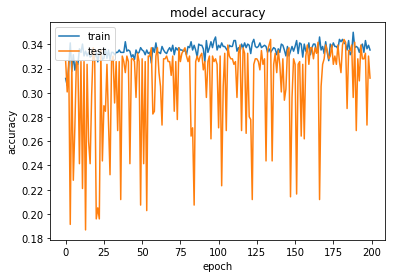

In [329]:
# summarize history for accuracy

plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

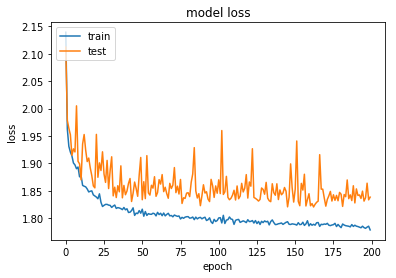

In [330]:
# summarize history for loss

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [331]:
scores = model.evaluate(X_test_rnn, y_test)
print('IRNN test score:', scores[0])
print('IRNN test accuracy:', scores[1])

439/439 [==============================] - 0s 1ms/step
IRNN test score: 1.838252393422746
IRNN test accuracy: 0.3120728928027229
